## Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Bayesian linear classifiers

In this example you are going to fit a Bayesian logistic regression model, using two sets of features on data $\mathbf{x} \in \mathbb{R}^2.

The first one is a "simple" set of features, with just the two input features plus an intercept:

$$\begin{align*}
\phi_{\text{simple}}(\mathbf{x}) &= [ 1, x_1, x_2 ]
\end{align*}$$

The second is up to you! For example, you could consider a set of quadratic polynomial features,

$$\begin{align*}
\phi_{\text{quadratic}}(\mathbf{x}) &= [ 1, x_1, x_2, x_1x_2, x_1^2, x_2^2 ].
\end{align*}$$

This example just includes quadratic terms, but you could also include higher order polynomial terms (e.g. $x_1^3, x_2^3$) or completely different features alltogether. It's up to you — but you should be prepared to justify your choice!

You will also fit the model in two different ways:

1. MAP estimation (penalized maximum likelihood)
2. Laplace approximation (a Gaussian approximate posterior, centered at the mode)

Here is a synthetic dataset that we'll be working with (plotting the training set only):

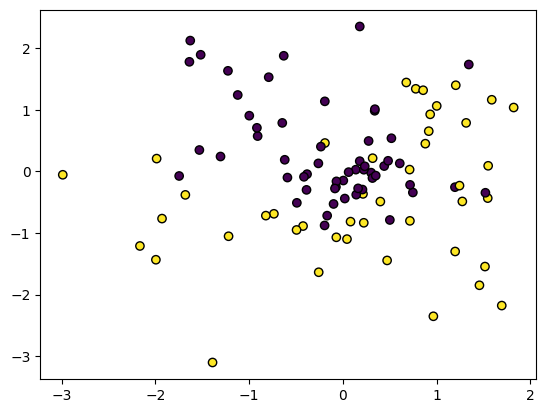

In [2]:
X_train, y_train, X_test, y_test = torch.load("data.pt")
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolors='k');

Here are definitions of two different feature maps, the "simple" one and the "quadratic" one.

They define feature spaces in $\mathbb{R}^3$ and $\mathbb{R}^6$, respectively.

In [3]:
def features_simple(X):
    return torch.concat((torch.ones_like(X[:,:1]), X), -1)

def features_quadratic(X):
    interactions = X.prod(-1, keepdim=True)
    return torch.concat((torch.ones_like(X[:,:1]), 
                         X, X.pow(2), interactions), -1)

print("Dimension of Phi, `features_simple`:", features_simple(X_train).shape)
print("Dimension of Phi, `features_quadratic`:", features_quadratic(X_train).shape)

Dimension of Phi, `features_simple`: torch.Size([100, 3])
Dimension of Phi, `features_quadratic`: torch.Size([100, 6])


# TASK #1 (3 points): Define the model

The Bayesian logistic regression model we are working with has the form
$$\begin{align*}
\mathbf{w} &\sim \mathcal{N}(0, \sigma^2 \mathbf{I}) \\
\hat y_i &= \mathrm{Logistic}(\mathbf{w}^\top \phi(\mathbf{x}_i)) \\
y_i &\sim \mathrm{Bernoulli}(\hat y_i)
\end{align*}$$
where $i = 1,\dots, N$ and the Logistic function is defined
$$\begin{align*}
\mathrm{Logistic}(z) &= \frac{1}{1 + \exp\{-z\}}.
\end{align*}$$
It's implemented in pytorch as `torch.sigmoid`.

The first step is to define two functions, one to make predictions given a weight vector $\mathbf{w}$ and inputs $\Phi$, and one which computes the log joint probability

$$\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

I've done the first one for you.

In [4]:
def predict_probs_MAP(Phi, w):
    """
    Given a "design matrix" Phi, and a point estimate w, compute p(y = 1 | Phi, w)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w     : (D,) vector of weights

    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi, w)
    """
    return torch.sigmoid(Phi @ w)

In [5]:
def log_joint(Phi, y, w, sigma=10):
    """
    Compute the joint probability of the data and the latent variables.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w     : (D,) vector of weights
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    log_joint : the log probability log p(y, w | Phi, sigma), a torch scalar
        
    """
    
    
    N, D = Phi.shape
    #lp_w = dist.multivariateNormal(torch.zeros(D), torch.eye(D)/alpha).log_prob(w)
    #lp_y = dist.Normal(torch.matmul(Phi, w.unsqueeze(-1)).squeeze(-1), 1.0/beta.sqrt()).log_prob(y).sum(-1)

    y_hat = predict_probs_MAP(Phi, w)
    lp_w = dist.MultivariateNormal(torch.zeros(D), torch.eye(D)*(sigma**2)).log_prob(w)
    
    lp_y = dist.Bernoulli(y_hat).log_prob(y).sum()
    
    return lp_y + lp_w


In [6]:
# (GRADING)

In [7]:
# (GRADING)

# TASK 2 (5 points): Implement MAP estimation

Now you need to write a function which performs MAP estimation, i.e. penalized maximum likelihood estimation.

This function should find the value $\mathbf{w}_{MAP}$ that maximizes the log joint, i.e.

$$\mathbf{w}_{MAP} = \mathrm{argmax}_{\mathbf{w}}\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

To do this, you should **use pytorch autograd tools**. This will involve defining an initial value of the weights, computing a scalar loss function, and calling `.backward()`, and then performing gradient-based optimization. Take a look at the demo notebooks from previous lectures for examples…!

* You **may feel free to use classes from `torch.optim`**. I would suggest the use of `torch.optim.SGD` or `torch.optim.Adagrad`.
* Regardless of how you do this, you will need to decide on a stopping criteria for your optimization routine.
* You will also need to decide on how to set the parameters (learning rate, momentum, anything else!) for your selected optimizer.

Also, **your code should work for ANY features!**. We will test this out on not just the "simple" and "quadratic" features above, but also on your own custom choice of features.

In [8]:
def find_MAP(Phi, y):
    """
    Find the MAP estimate of the log_joint method.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones


    OUTPUT:
    w      : (D,) vector of optimized weights
    losses : list of losses at each iteration of the optimization algorithm.
             Should be a list of scalars, which can be plotted afterward to
             diagnose convergence.
    """
    
    # Initializing
    N, D = Phi.shape
    weights = torch.zeros(D).requires_grad_(True)
    sigma = torch.tensor(10)
    log_sigma = torch.tensor(10).log().requires_grad_(True)
    losses = []
    
    init = torch.linalg.inv(Phi.T @ Phi + log_sigma.detach().exp()*torch.eye(Phi.shape[1])) @ (Phi.T @ y)
    params = [weights]
    
    

    
# Computing a scalar loss fcn
    # Defining optimizer
    opt = torch.optim.Adagrad(params , lr = 0.1)
    
    for r in range(1000):
        # ZERO THE GRADIENTS
        opt.zero_grad()

        # FORWARD PASS
        q_w = dist.MultivariateNormal(torch.FloatTensor(init).requires_grad_(True),
                           (torch.eye(D)*(sigma**2)).requires_grad_(True)) # prop dist sigma = 10
        
        loss = - (log_joint(Phi, y, weights) - q_w.log_prob(weights))
        
        # BACKWARD PASS
        loss.backward()

        # OPTIMIZER (+ value save)
        losses.append(loss.item())
        opt.step()
    
    
    return weights.detach(), losses


### The following two cells call `find_MAP` to compute $\mathbf{w}$ for both choices of features.

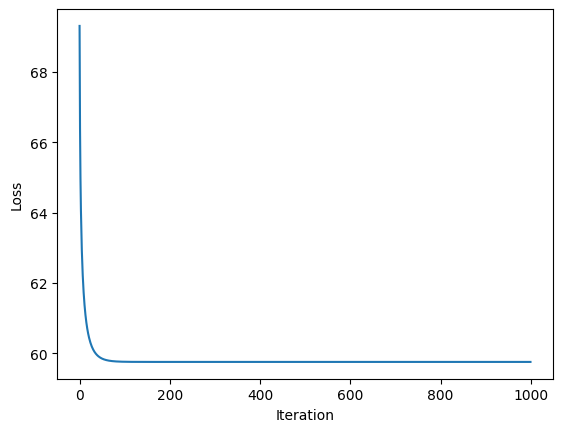

In [9]:
w_MAP_simple, losses = find_MAP(features_simple(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

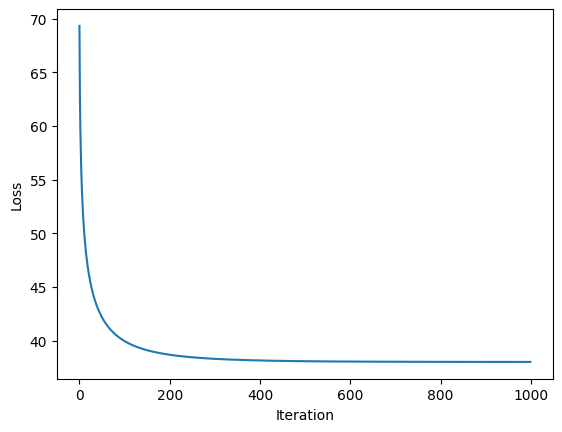

In [10]:
w_MAP_quad, losses = find_MAP(features_quadratic(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [11]:
# (GRADING)

In [12]:
# (GRADING)

## Visualization: The following code visualizes the classifier result

It plots the probability of being one class or the other using a color contour plot.

The decision boundary is a dashed black line.

In [13]:
def plot_boundary(X, y, pred):
    h = 0.2
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = pred(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.8, levels=np.linspace(0, 1, 8))
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    
    plt.contour(xx, yy, Z, levels=(0.5,), linestyles='dashed');
    
    # Plot the testing points
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

Simple features: training accuracy = 0.68, test accuracy = 0.68


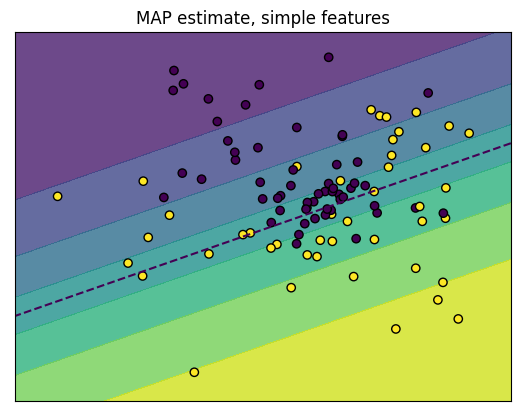

In [14]:
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))
plt.title("MAP estimate, simple features")
train_accuracy = (predict_probs_MAP(features_simple(X_train), w_MAP_simple).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_simple(X_test), w_MAP_simple).round() == y_test).float().mean()
print("Simple features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

Polynomial features: training accuracy = 0.86, test accuracy = 0.92


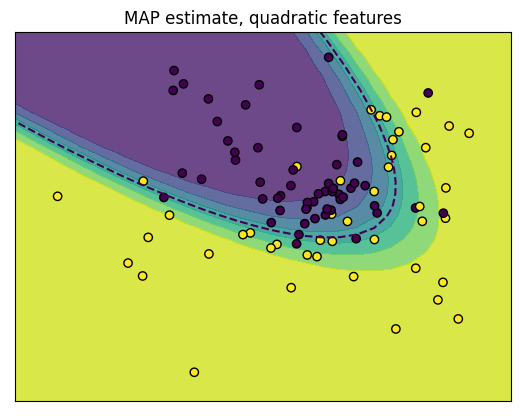

In [15]:
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))
plt.title("MAP estimate, quadratic features")
train_accuracy = (predict_probs_MAP(features_quadratic(X_train), w_MAP_quad).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_quadratic(X_test), w_MAP_quad).round() == y_test).float().mean()
print("Polynomial features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

# TASK #3 (5 points): Laplace approximation

In the next section, you will fit an approximate posterior over the weights by using the Laplace approximation around the mode $\mathbf{w}_{MAP}$ of the distribution you found above.

This requires completing two functions:

1. `compute_laplace_Cov` takes the data and the MAP estimate, and outputs a covariance matrix defined as the negative inverse Hessian of the log target density. (See the week 4 lecture slides for details on how to compute this!)
2. `predict_bayes` makes predictions on new data points, by approximating $\int p(y | x, w)p(w | \mathcal{D})dw$ when using a Gaussian approximation to $p(w | \mathcal{D})$. In the week 4 lecture slides we discussed three different ways of computing this — it is up to you to decide what method you would prefer, and implement it.

In [16]:
def compute_laplace_Cov(Phi, y, w_MAP, prior_std=10):
    """
    Compute the Laplace approximation of the posterior covariance 
    in a logistic regression setting.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    Cov : (D, D) posterior covariance matrix estimate defined by the Laplace 
          approximation
    """
    N, D = Phi.shape
    Hessian = np.zeros([D, D])
    
    S_o_inv = torch.eye(D)*(1/prior_std**2)
    
    y_hat = predict_probs_MAP(Phi, w_MAP)
    
    term = 0.0
    for n in range(N):
        phi_n = Phi[n].reshape([D,1])
        term += y_hat[n] * (1 - y_hat[n]) * torch.matmul(phi_n, phi_n.T)
    
    S_n_inv = S_o_inv + term
    
    Cov = torch.linalg.inv(S_n_inv)
    
    return Cov

# TRY : torch.einsum('ij,jk,ik->i', Phi, S_o_inv, Phi)

In [17]:
def predict_bayes(Phi, w_MAP, Cov):
    """
    Make predictions on new data points using an approximate posterior 
    w ~ MultivariateNormal(w_MAP, Cov)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi)
    """
    
    # 'Interesting' alternative interpretation P(y = 1 | x, D) ~= sig( mu_a / sqrt(1 + pi*sig_a^2/8))
    
    N, D = Phi.shape
    
    y_hat = torch.zeros([N,])
    
    for n in range(N):
        phi_n = Phi[n].reshape([1,D])
        mu = Phi[n] @ w_MAP
        sig_sqr = phi_n @ Cov @ phi_n.T
        ratio = mu / torch.sqrt(1 + torch.pi * sig_sqr / 8)
        y_hat[n] = torch.sigmoid(ratio)
    
    return y_hat

### The following cells call your functions above to compute the Laplace approximation and visualize the posterior predictive distribution.

In [18]:
Cov_simple = compute_laplace_Cov(features_simple(X_train), y_train, w_MAP_simple)

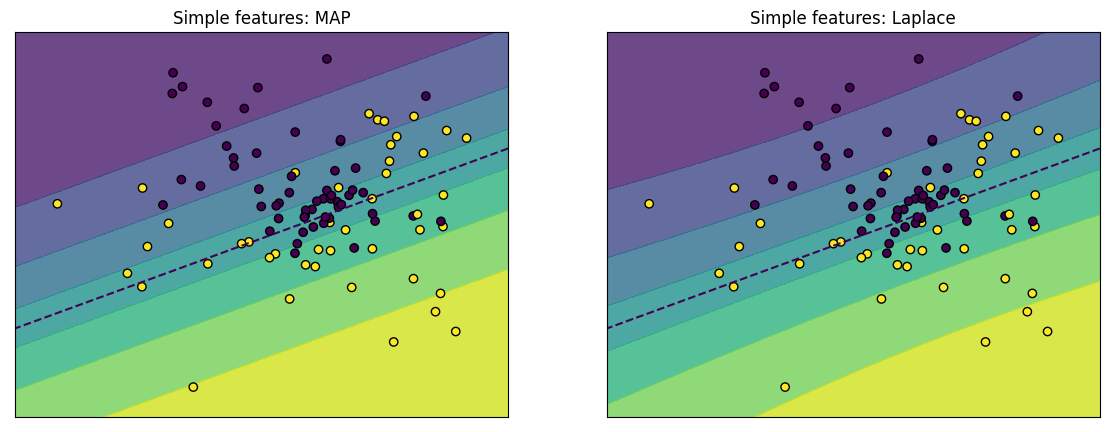

In [19]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Simple features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))

plt.subplot(122)
plt.title("Simple features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_simple(X), w_MAP_simple, Cov_simple))

In [20]:
Cov_quad = compute_laplace_Cov(features_quadratic(X_train), y_train, w_MAP_quad)

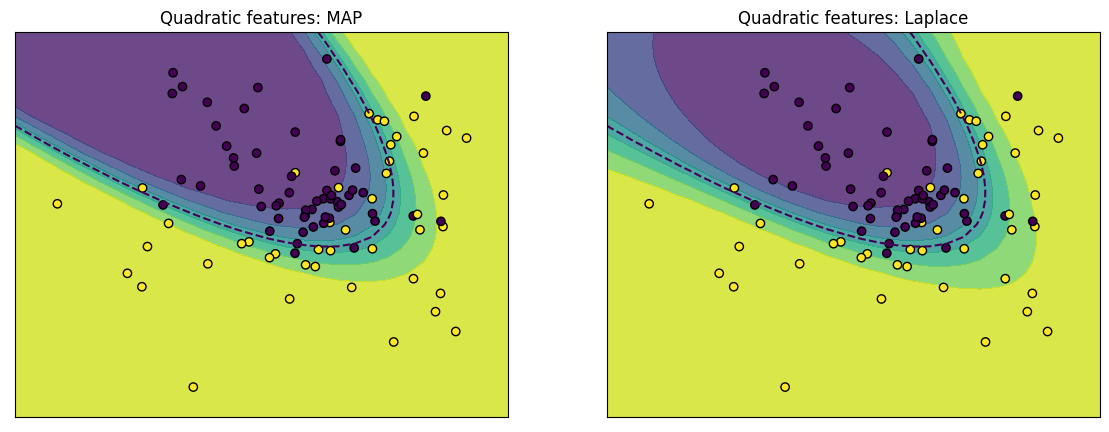

In [21]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Quadratic features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))

plt.subplot(122)
plt.title("Quadratic features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_quadratic(X), w_MAP_quad, Cov_quad))

In [22]:
# (GRADING)

In [23]:
# (GRADING)

In [24]:
# (GRADING)

# TASK #4 (2 points): Model comparison

You can compute the marginal likelihood approximation defined by the Laplace approximation.

This estimate of the evidence can be used, even just looking at the training data, to help decide which of the two feature maps is more appropriate and better fits the data.

This can help guard against potential overfitting if using features that are "too complex".

In [25]:
def compute_laplace_log_evidence(Phi, y, w_MAP, Cov):
    """
    This computes the Laplace approximation to the marginal likelihood,
    as defined in the Week 5 lectures.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    log_evidence : scalar value estimating `log p(y | Phi)`
    """
    N, D = Phi.shape
    
    Hessian = torch.linalg.inv(Cov)
    Lambda = torch.det(Hessian)
    
    p_yw = log_joint(Phi, y, w_MAP)
    p_pi = (D/2)*np.log(2 * torch.pi)
    p_Lambda = (1/2)*np.log(Lambda)
    
    laplace_log = p_yw + p_pi - p_Lambda
    
    return laplace_log

In [26]:
print("Model evidence estimate (simple features):",
      compute_laplace_log_evidence(features_simple(X_train), y_train, w_MAP_simple, Cov_simple).item())

print("Model evidence estimate (polynomial features):",
      compute_laplace_log_evidence(features_quadratic(X_train), y_train, w_MAP_quad, Cov_quad).item())

Model evidence estimate (simple features): -70.93025207519531
Model evidence estimate (polynomial features): -57.54754638671875


In [27]:
# (GRADING)

# TASK #5 (2 points + 4 points): Define your own feature space

Your next task is to define your own, custom feature space! This can be practically any deterministic function from $\mathbb{R}^2$ to $\mathbb{R}^D$, and you even get to pick the dimensionality $D$.

In the following cells, you first define your feature space, and then we estimate the posterior using your code above. We report training accuracy, test accuracy, and model evidence, as well as plot the decision boundaries.

Feel free to get quite creative here! However, you will be asked to defend your choice of feature space in the free-answer section at the bottom.

**Make sure when you submit, you include whatever you consider the "best" possible choice!**

In [35]:
def features_student(X):
    """
    Compute your own, custom set of features!
    
    INPUT:
    X      : (N, 2) tensor of raw input data
    
    OUTPUT:
    Phi    : (N, D) tensor of transformed inputs
    """
    
    N, n = X.shape
    
    # CUBIC FEATURES
    D_cubic = 10
    features_cubic = torch.zeros([N,D_cubic])
    
    for n in range(N):
        x = X[n]
        x0 = x[0]
        x1 = x[1]
        features_cubic[n] = torch.tensor([1, x0, x1, x0*x1, x0**2, x1**2, x0*(x1**2), (x0**2)*x1, x0**3, x1**3]) 
        
        
    # QUARTIC FEATURES
    
    D_quartic = 15
    features_quartic = torch.zeros([N,D_quartic])
    
    for n in range(N):
        x = X[n]
        x0 = x[0]
        x1 = x[1]
        features_quartic[n] = torch.tensor([1, x0, x1, x0*x1, x0**2, x1**2, x0*(x1**2), (x0**2)*x1, x0**3, x1**3, (x0**3)*x1, (x0**2)*(x1**2), x0*(x1**3), x0**4, x1**4])
        
        
    # QUINTIC FEATURES
    
    D_quintic = 21
    features_quintic = torch.zeros([N,D_quintic])
    
    for n in range(N):
        x = X[n]
        x0 = x[0]
        x1 = x[1]
        features_quintic[n] = torch.tensor([1, x0, x1, x0*x1, x0**2, x1**2, x0*(x1**2), (x0**2)*x1, x0**3, x1**3, (x0**3)*x1, (x0**2)*(x1**2), x0*(x1**3), x0**4, x1**4, (x0**5), (x0**4)*x1, (x0**3)*(x1**2), (x0**2)*(x1**3), (x0)*(x1**4), x1**5])

        
    # EXP - sorta - FEATURES
    
    D_exp = 3
    features_exp = torch.zeros([N,D_exp])
    for n in range(N):
        x = X[n]
        x0 = x[0]
        x1 = x[1]
        features_exp[n] = torch.tensor([torch.exp(x0), torch.exp(x1), torch.exp(x0+x1)])
        
    # SUM POLY FEATURES
    
    D_sump = 4
    features_sump = torch.zeros([N,D_sump])
    for n in range(N):
        x = X[n]
        x0 = x[0]
        x1 = x[1]
        features_sump[n] = torch.tensor([x0**4, x1**3, torch.sqrt(x0**2 + x1**2), (x0 + x1)**4])
        
    # SINUSOIDAL FEATURES
    
    D_sin = 4
    features_sin = torch.zeros([N,D_sin])
    for n in range(N):
        x = X[n]
        x0 = x[0]
        x1 = x[1]
        features_sin[n] = torch.tensor([torch.sin(x1), torch.cos(x0), x0, x1**2])
    
    return features_sump
    

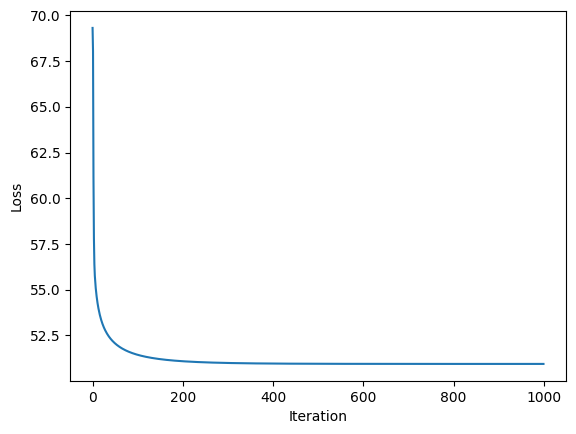

In [36]:
w_MAP_student, losses = find_MAP(features_student(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [37]:
train_accuracy = (predict_probs_MAP(features_student(X_train), w_MAP_student).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_student(X_test), w_MAP_student).round() == y_test).float().mean()
print("YOUR features! Training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))



YOUR features! Training accuracy = 0.81, test accuracy = 0.90


In [38]:
Cov_student = compute_laplace_Cov(features_student(X_train), y_train, w_MAP_student)

print("YOUR features! Model evidence estimate:",
      compute_laplace_log_evidence(features_student(X_train), y_train, w_MAP_student, Cov_student).item())

YOUR features! Model evidence estimate: -67.93431854248047


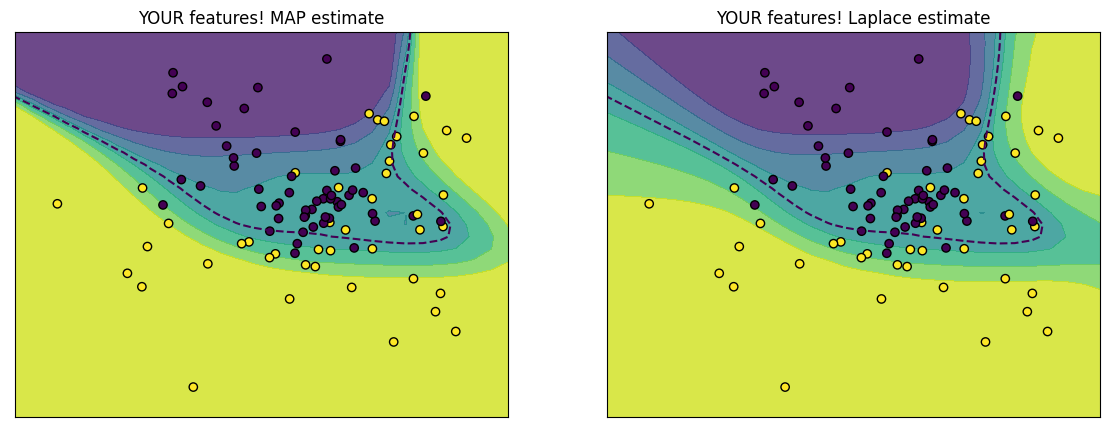

In [39]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("YOUR features! MAP estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_student(X), w_MAP_student))

plt.subplot(122)
plt.title("YOUR features! Laplace estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_student(X), w_MAP_student, Cov_student))

# Please answer the following short questions:

1. *[Feature selection]* How did you choose your features? Name at least two ways of comparing whether one set of features is "better" than another. Would these methods generally yield the same "ranking" of different features? Why or why not?
2. *[Overfitting]* Is "overfitting" possible in this setting? Did you experience it? If so, how would you detect it? Does using the Laplace approximation "help" with overfitting, or does it not make a difference? Justify your answer.

1. [Feature Selection]

CHOOSING FEATURES

I chose my features very carefully and compared my chosen features to 4 other feature maps in addition to the 'simple features' and 'polynomial features' the problem provided. By looking at the data, on the visualizations on the posterior predictive distributions that were performed on the simple and polynomial features above, it is worth noticing the general curved shape about a positive-looking relationship. This gave me the idea was perhaps polynomial to an odd-numbered degree. Then, with the model evidence estimate for simple features coming in at -70.93025207519531 and the model evidence estimate for the polynomial features being -57.54754638671875, it was shown that the additional features were making a positive predictive contribution (in the case between the simple and  quadratic). This is how I decided to try cubic features. The cubic model evidence estimate is -57.30918884277344 which was the best yet. The model with these cubic features also have a high training accuracy with 0.90 and an even higher testing accuracy which is 0.92.

Although relatively happy with the cubic features, I decided to see if quatric and quintic polynomial features lead to an improvement or just overfit. The quatric features gave the same training and test accuracy as the cubic, however it gave a lower model evidence estimate of -67.95442199707031. The quintic showed its hand in overfitting with the highest training accuracy of 0.91 but lower test accuracy of 0.86. Additionally the quintic polynomial features has an even lower model evidence estimate of -73.18757629394531. 

After the pure polynomial fitting, I tried out some combinations of expential relationships as well of sums of polynomials just to get some better insight into feature mapping in general (more for my own knowledge but I thought I would share). The exponential-ish features did alright with their training accuracy of 0.75, test accuracy of 0.7, and model evidence estimate -68.0797348022461, but nothing to rival the the polynomial features. Noticing the somewhat circular cluster of data, I played around with sinusoidal features in combination with powers. After a few trials of different combinations, I was able to get the model evidence estimate down to -64.19879913330078 but the accompanying test accuracy was refusing to reach higher than 0.82. Now truly appreciating my previous polynomial features, I combined summed a few polynomials in a new set of features to see the impact. The test accuracy of this feature got to 0.90 and the model evidence came in at -67.93431854248047, however the cubic features remains the overall champion.


FEATURE COMPARISON

Comparison 1: the test accuracy of the models with different features. This tells us how well the model trained on the training set fits the values of the test set.

Comparison 2: the model evidence estimate. This tells us the amount of the results that are explained by the model.

RANKING COMPARISON

While the test accuracy and model evidence estimates do generally correspond. That is, lower test accuracy tends to correspond with a lower model evidence estimate. However, this is not always the case. The exponential(ish) features had a test accuracy of 0.7 and a model evidence estimate of about -68 while the quintic features had a higher test accuracy of 0.86 but a lower model evidence estimate of about -73. That said, generally the more evidence supporting the model and the accuracy on new data would intuitively correspond is the training data is representative of the environment.

2. [Overfitting] 

OVERFITTING POSSIBILITY

Yes, it is possible to overfit in this setting. This is seen with the quartic and quintic polynomial features expressed above. The quintic had the highest training accuracy but the additional features were shown to be overfitting from the corresponding and lower test accuracy of 0.86.


LAPLACE OVERFITTING CONTRIBUTION

From analyzing the quintic features MAP estimate versus Laplace estimate, it appears as though the Laplace estimate would help smooth out the steepness about the separating curve but not impact the actual curve substantially so I do not think that the Lapplace significantly contributed to overfitting in this model.

#### Ignore the following cells. They are used by the grading system.

In [33]:
# (GRADING)

In [34]:
# (GRADING)